In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import math
import random
from ann_visualizer.visualize import ann_viz
import os
import json
import eli5
from eli5.sklearn import PermutationImportance
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

In [2]:
def convert_month(df):
    unique_zips = np.unique(df_train.zip)

    df_ls = []
    for z in unique_zips:
        df_sub = df[df.zip == z]
        df_sub['month_continuous'] = list(range(1,df_sub.shape[0]+1))
        df_ls.append(df_sub)
    return pd.concat(df_ls)

def agg_monthly(col_to_agg, df_train, df_test, groupby_cols):
    # connvert month
    df_train_v2 = convert_month(df_train)
    df_test_v2 = convert_month(df_test)
    
    # aggregate monthly
    df_train_agg = df_train_v2.groupby(groupby_cols).aggregate(col_to_agg).reset_index()
    df_test_agg = df_test_v2.groupby(groupby_cols).aggregate(col_to_agg).reset_index()

    return df_train_agg, df_test_agg

def split_sequence3(df, x_cols, y_col, n_steps):
    X,y = [],[] 
    zips = np.unique(df.zip)
    
    # loop through all zips
    for i in range(zips.shape[0]): 
        
        # subset to this zipcode
        df_zip = df[df.zip == zips[i]]
        full_dim = df_zip.shape[0]
        
        for j in range(full_dim):
            # find the end of this pattern
            
            end_jx = j + n_steps
            out_end_ix = end_jx + n_steps

            # check if we are beyond the sequence
            if out_end_ix > full_dim:
                break

            # else, gather input and output parts of the pattern
            x_sub_seq = df_zip[x_cols].iloc[j:end_jx]
            y_sub_seq = df_zip[y_col].iloc[end_jx:out_end_ix]
#             y_sub_seq = df_zip[y_col].iloc[end_jx]

            X.append(x_sub_seq.values)
            y.append(y_sub_seq.values)
#             zip_ls.append(zips[i])
#         break

    return np.array(X), np.array(y)

def split_sequence4(df, x_cols, y_col, n_steps):
    X,y = [],[] 
    zips = np.unique(df.zip)
    
    # loop through all zips
    for i in range(zips.shape[0]): 
        
        # subset to this zipcode
        df_zip = df[df.zip == zips[i]]
        full_dim = df_zip.shape[0]
        
        for j in range(full_dim):
            print(j)
            # find the end of this pattern
            
            end_jx = j + n_steps
            out_end_ix = end_jx 
            
            # check if we are beyond the sequence
            if out_end_ix >= full_dim:
                break
                

            # else, gather input and output parts of the pattern
            x_sub_seq = df_zip[x_cols].iloc[j:end_jx]
            y_sub_seq = df_zip[y_col].iloc[out_end_ix]

            X.append(x_sub_seq.values)

        break
    return np.array(X), np.array(y)

def normalize_data(X_train, X_test=None):
    scaler = MinMaxScaler()
    if X_test is not None:
        X_train_normalized = scaler.fit_transform(X_train)
        X_test_normalized = scaler.transform(X_test)
        return X_train_normalized,X_test_normalized
    else:
        X_train_normalized = scaler.fit_transform(X_train)
        return X_train_normalized

def standardize(X_train, X_test=None):
    
    scaler = StandardScaler().fit(X_train)
    # if x_test is passed in, or just x_train 
    if X_test is not None:
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        return X_train, X_test
    else:
        X_train = scaler.transform(X_train)
        return X_train  
    
    
# Plot history
def plot_training_history(history, title, save_label):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure(figsize=(10,7))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title,fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel("Loss",fontsize=15)
    plt.legend()
    plt.savefig(save_label)
    plt.show()

In [3]:
# Store model
def store_keras_model(model, model_name):
    """Save model and weights as model_name in models folder
    
    :param model: trained Keras model object
    :param model_name: str, name under which to save the model
    """
    # serialize model to JSON
    model_json = model.to_json()
    if not os.path.exists("models"):
        os.mkdir("models")
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("./models/{}.h5".format(model_name))
    print("Saved model to disk")


# Load model 
def load_keras_model(model_name):
    """Load model_name from models folder in working directory
    
    :param model_name: str, name of saved model
    :return: Keras model object loaded from disk
    """
    # Load json and create model
    json_file = open("./models/{}.json".format(model_name), "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

# serialize and deserialize training history as json
# so we can restore our notebook state without re-training models

class make_simple_history_obj():
    """Create simple class that imitates TensorFlow history object API
    """
    def __init__(self, history_dict):
        """Create history attribute containing history dict
        """
        self.history = history_dict
        
def save_model_history(history, filename):
    """Serialize TensorFlow model history and save to json
    """
    history_dict = history.history # get dict from history object
    if not os.path.exists('models'):
        os.mkdir('models')
    with open("./models/{}.json".format(filename), "w") as json_file:
        json.dump(history_dict, json_file)
    
def load_model_history(filename):
    """Read history dict from json and return simple history object
    """
    with open("./models/{}.json".format(filename), "r") as json_file:
        history_dict = json.load(json_file)
    return make_simple_history_obj(history_dict)


class make_simple_optimizer_obj():
    """Create simple class that imitates TensorFlow history object API
    """
    def __init__(self, optimizer):
        """Create history attribute containing history dict
        """
        self.optimizer = optimizer
        
def write_config(model, filename):
    with open("./models/{}.json".format(filename), "w") as f:
        json.dump(str(model.optimizer.get_config()), f, indent=4, sort_keys=True)
    
def read_config(filename):
    """Read history dict from json and return simple history object
    """
    with open("./models/{}.json".format(filename), "r") as json_file:
        optimizer = json.load(json_file)
    return make_simple_optimizer_obj(optimizer)

In [4]:
def compute_yr_preds(pred, cols):
    preds_ls = []
    # compute yearly average (model returns 12 months)
    pred_yr_ave = np.sum(pred,axis=1)
    i = 0
    while i < pred.shape[0]:
        # new zipcode after every 49th sample
        j=i+49
        pred_new_zip = pred_yr_ave[i:j]

        # skip every 12th window to get full new year predictions
        pred_new_zip_years = list(pred_new_zip[::12]) 
        
        # save to list of lists
        preds_ls.append(pred_new_zip_years)
        i=j
    preds_df = pd.DataFrame(preds_ls,columns=cols)
    return preds_df

  
def compute_month_preds(pred, cols, zips):
    preds_ls = []
    # compute yearly average (model returns 12 months)
    i = 0
    while i < pred.shape[0]:
        # new zipcode after every 49th sample
        j=i+49
        pred_new_zip = pred[i:j]

        # skip every 12th window to get full new year predictions
        pred_new_zip_years = list(pred_new_zip[::12]) 
        # save to list of lists
        preds_ls.append(pred_new_zip_years)
        i=j
    preds_df = pd.DataFrame(preds_ls,columns=cols)
    preds_df['zip'] = zips
    return preds_df

def var_importance(model, X, x_col1, num_repeats=1):
    pert_effects = []
    orig_out = model.predict(X)
    print('predicted original')
    if num_repeats >1:
        for r in range(num_repeats):
            pert_effects_r = []
            for i in range(len(x_col1)):  # iterate over the three features
                new_x = X.copy()
                perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
                new_x[:, :, i] = new_x[:, :, i] + perturbation
                perturbed_out = model.predict(new_x)
                effect = ((orig_out - perturbed_out) ** 2).mean() #** 0.5
                pert_effects_r.append(effect)
            print('repeat complete')
            pert_effects.append(pert_effects_r)
        return pert_effects
    else:
        for i in range(len(x_col1)):  # iterate over the three features
            new_x = X.copy()
            perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
            new_x[:, :, i] = new_x[:, :, i] + perturbation
            perturbed_out = model.predict(new_x)
            effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
            pert_effects.append(effect)
            print(x_col1[i] + f', perturbation effect: {effect:.4f}')
#             break
        return pert_effects

In [67]:
def split_sequence_and_standardize(df, x_col1, y_col1, non_binary_preds, n_steps, standardized=True, save=False):
    
    xdim2 = len(x_col1)
    
    # randomly split by zip
    zips = np.unique(df.zip)
    zips_test = list(np.random.choice(zips, round(zips.shape[0]*.25)))
    zips_train  = [x for x in zips if x not in zips_test]
    df_train_new = df[df.zip.isin(zips_train)].sample(frac=1) # shuffle
    df_test_new = df[df.zip.isin(zips_test)]
    
    # add continuous month
    df_train_agg2, df_test_agg2 = convert_month(df_train_new),convert_month(df_test_new)
    
    # create windows
    X_train_rnn, y_train_rnn = split_sequence3(df_train_agg2, x_col1, y_col1, n_steps)
    X_test_rnn, y_test_rnn = split_sequence3(df_test_agg2, x_col1, y_col1, n_steps)
    
    # reshape y
    y_train_rnn_re = y_train_rnn.reshape((y_train_rnn.shape[0],y_train_rnn.shape[1]))
    y_test_rnn_re = y_test_rnn.reshape((y_test_rnn.shape[0],y_test_rnn.shape[1]))
    
    
    if standardized:
        # reshape
        X_train_rnn_re = X_train_rnn.reshape((X_train_rnn.shape[0]*X_train_rnn.shape[1],xdim2))
        X_test_rnn_re = X_test_rnn.reshape((X_test_rnn.shape[0]*X_test_rnn.shape[1],xdim2))
        
        # standardize
        X_train_rnn_standardized,X_test_rnn_standardized = standardize(X_train_rnn_re, X_test_rnn_re)
        
        # rehsape
        X_train_rnn_standardized = X_train_rnn_standardized.reshape(X_train_rnn.shape)
        X_test_rnn_standardized = X_test_rnn_standardized.reshape(X_test_rnn.shape)
        
        if save:
            # save
            pd.DataFrame(X_train_rnn_re).to_csv('X_train_rnn_re.csv')
            pd.DataFrame(y_train_rnn_re).to_csv('y_train_rnn_re.csv')
            pd.DataFrame(X_test_rnn_re).to_csv('X_test_rnn_re.csv')
            pd.DataFrame(y_test_rnn_re).to_csv('y_test_rnn_re.csv')
        
        return X_train_rnn_standardized, y_train_rnn_re, X_test_rnn_standardized, y_test_rnn_re
    else:
        return X_train_rnn, y_train_rnn_re,  X_test_rnn, y_test_rnn_re

def standardize2(non_binary_preds,X_train, X_test=None):
    scaler = StandardScaler().fit(X_train[non_binary_preds])
    if X_test is not None:
        X_train[non_binary_preds] = scaler.transform(X_train[non_binary_preds])
        X_test[non_binary_preds] = scaler.transform(X_test[non_binary_preds])
        return X_train, X_test
    else:
        X_train[non_binary_preds] = scaler.transform(X_train[non_binary_preds])
        return X_train  
    
def split_sequence_and_standardize2(df, x_col1, y_col1, non_binary_preds, n_steps, standardized=True, save=False):
    
    xdim2 = len(x_col1)
    
    # randomly split by zip
    zips = np.unique(df.zip)
    zips_test = list(np.random.choice(zips, round(zips.shape[0]*.25)))
    zips_train  = [x for x in zips if x not in zips_test]
    df_train_new = df[df.zip.isin(zips_train)].sample(frac=1) # shuffle
    df_test_new = df[df.zip.isin(zips_test)]
    
    # add continuous month
    df_train_agg2, df_test_agg2 = convert_month(df_train_new),convert_month(df_test_new)
    
    # standardize
    X_train_pre, X_test_pre = standardize2(non_binary_preds,df_train_agg2[x_col1], df_test_agg2[x_col1])
    
    # prep for creating sequence windows
    df_train_pre = pd.concat((pd.DataFrame(X_train_pre,columns=x_col1),df_train_agg2[y_col1]),axis=1)
    df_test_pre = pd.concat((pd.DataFrame(X_test_pre,columns=x_col1),df_test_agg2[y_col1]),axis=1)
    df_train_pre['zip'] = df_train_agg2['zip']
    df_test_pre['zip'] = df_test_agg2['zip']
    
    print('prepped for extracting windows. now splitting sequence...')
#     print(df_train_pre.head(5))
    
    # create windows
    X_train_rnn, y_train_rnn = split_sequence3(df_train_pre, x_col1, y_col1, n_steps)
    X_test_rnn, y_test_rnn = split_sequence3(df_test_pre, x_col1, y_col1, n_steps)
    y_train_rnn_re = y_train_rnn.reshape((y_train_rnn.shape[0],y_train_rnn.shape[1]))
    y_test_rnn_re = y_test_rnn.reshape((y_test_rnn.shape[0],y_test_rnn.shape[1]))
                                             
    if save:
        # reshape
        X_train_rnn_re = X_train_rnn.reshape((X_train_rnn.shape[0]*X_train_rnn.shape[1],xdim2))
        X_test_rnn_re = X_test_rnn.reshape((X_test_rnn.shape[0]*X_test_rnn.shape[1],xdim2))

        # save
        pd.DataFrame(X_train_rnn_re).to_csv('X_train_rnn_re.csv')
        pd.DataFrame(y_train_rnn_re).to_csv('y_train_rnn_re.csv')
        pd.DataFrame(X_test_rnn_re).to_csv('X_test_rnn_re.csv')
        pd.DataFrame(y_test_rnn_re).to_csv('y_test_rnn_re.csv')                          
        
    return X_train_rnn, y_train_rnn_re, X_test_rnn, y_test_rnn_re


# does not work for 3-d output
def gru_predict(sample):
    preds = gru_model.predict(sample.reshape((1,12,54)))
    yrly_pred = np.sum(preds,axis=1)
    return yrly_pred
    
def explain_local(X_train_standardized, X_test_standardized, x_col1,y_col1, model, i,n, gru_predict):
    explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train_standardized, 
                                                            feature_names = x_col1,
                                                           discretize_continuous=True,
                                                           class_names=y_col1,
#                                                            mode='regression',
                                                           discretizer='decile')
    
    exp = explainer.explain_instance(X_test_standardized[i,:,:], gru_predict, num_features=n)
    exp.show_in_notebook(show_table=True)
    return exp

### Simple RNN
- Data: 
    - 12 time steps
    - aggregated monthly over 5 years


In [58]:
df_train = pd.read_csv('data/zip_train_monthly.csv').drop(columns=['Unnamed: 0'])
df_test = pd.read_csv('data/zip_test_monthly.csv').drop(columns=['Unnamed: 0'])
df = pd.concat((df_train, df_test)).reset_index()

In [65]:
df2 = df.copy()
cs = ['year_2011','year_2012','year_2013','year_2014','year_2015','year_2016']

for i,y in enumerate(range(2011,2017)):
    df2[cs[i]] = 0
    y_ind = list(df2[df2['AYEAR']==y].index.values)
    df2[cs[i]].iloc[[y_ind]] = 1


# y = next 12 months
non_binary_preds = ['sex','mean_age', 'population','AYEAR',
       'poverty',  'medianhousevalue', 
       'medhouseholdincome', 'pct_owner_occ',  'education',
       'smoke_rate', 'mean_bmi', 'race_1', 'race_2',
       'race_3', 'race_4', 'race_5', 'race_6', 'ICU_DAY', 'CCI_DAY', 'LOS',
       'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25', 'CVD_pdx2dx_25', 
       'malignant_neoplasms','neo_210_229',
#         'neo_140_149','neo_150_159', 'neo_160_165', 'neo_170_176', 'neo_179_189',
#        'neo_190_199', 'neo_200_209',  'neo_230_234','neo_235_238', 'neo_239',
       'pm25_summer_4y_avg', 'pm25_winter_4y_avg',
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
       'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
       'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
       'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

x_col1 = cs + non_binary_preds 
y_col1 = ['deaths'] 
n_steps=12
xdim2 = len(x_col1)

In [68]:
X_train_rnn_standardized4, y_train_rnn4,  X_test_rnn_standardized4, y_test_rnn4 = split_sequence_and_standardize2(df2, x_col1, y_col1, non_binary_preds, n_steps,save=True)
# X_train_rnn_standardized4, y_train_rnn4,  X_test_rnn_standardized4, y_test_rnn4 = split_sequence_and_standardize(df, x_col1, y_col1, non_binary_preds, n_steps)


prepped for extracting windows. now splitting sequence...


In [69]:
X_train_rnn_standardized4.shape, y_train_rnn4.shape,  X_test_rnn_standardized4.shape, y_test_rnn4.shape

((603680, 12, 51), (603680, 12), (170079, 12, 51), (170079, 12))

### Read in saved data

In [7]:
X_train_rnn4_re=pd.read_csv('X_train_rnn_re.csv').drop(columns=['Unnamed: 0'])
y_train_rnn4_re=pd.read_csv('y_train_rnn_re.csv').drop(columns=['Unnamed: 0'])
X_test_rnn4=pd.read_csv('X_test_rnn_re.csv').drop(columns=['Unnamed: 0'])
y_test_rnn4=pd.read_csv('y_test_rnn_re.csv').drop(columns=['Unnamed: 0'])

x_col1 = ['sex','mean_age', 'population','AYEAR',
       'poverty',  'medianhousevalue', 
       'medhouseholdincome', 'pct_owner_occ',  'education',
       'smoke_rate', 'mean_bmi', 'race_1', 'race_2',
       'race_3', 'race_4', 'race_5', 'race_6', 'ICU_DAY', 'CCI_DAY', 'LOS',
       'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25',
       'Stroke_pdx2dx_25', 'CVD_pdx2dx_25', 
        'neo_140_149','neo_150_159', 'neo_160_165', 'neo_170_176', 'neo_179_189',
       'neo_190_199', 'neo_200_209', 'neo_210_229', 'neo_230_234',
       'neo_235_238', 'neo_239', 'pm25_summer_4y_avg', 'pm25_winter_4y_avg',
       'pm25_fall_4y_avg', 'pm25_spring_4y_avg', 'ozone_summer_4y_avg',
       'ozone_winter_4y_avg', 'ozone_fall_4y_avg', 'ozone_spring_4y_avg',
       'no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg',
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg', 'summer_rmax_4y_avg',
       'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']
n_steps=12
xdim2 = len(x_col1)

#standardize
x1,x2 = int(X_train_rnn4_re.shape[0]/12), int(X_test_rnn4_re.shape[0]/12)
X_train_rnn_standardized4,X_test_rnn_standardized4 = standardize(X_train_rnn4_re, X_test_rnn4_re)
X_train_rnn_standardized4 = X_train_rnn_standardized4.reshape((x1,n_steps,xdim2))
X_test_rnn_standardized4 = X_test_rnn_standardized4.reshape((x2,n_steps,xdim2))

#### Simple RNN

In [71]:
# hyperparameters
n_units = 60 #100
drop_rate = .1
# dim_embed = 50
n_steps=12

optimizer = tf.keras.optimizers.Adam(0.0001) # learning_rate=0.0001
# loss = "mse"
loss = tf.keras.losses.Poisson()
# loss = "mae"
# loss = tf.keras.losses.MeanSquaredLogarithmicError()
# loss = tf.keras.losses.KLDivergence()
metrics = ["mse"]

batch_size = 49
epochs = 8
validation_split = 0.1
verbose = 1

# define model
rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Input(shape=(n_steps,xdim2)))
rnn_model.add(tf.keras.layers.SimpleRNN(n_units,return_sequences=True))
rnn_model.add(tf.keras.layers.BatchNormalization())           
rnn_model.add(tf.keras.layers.Dropout(drop_rate))
rnn_model.add(tf.keras.layers.SimpleRNN(n_units, return_sequences=True))
rnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='relu'))) # linear
# Compile model
rnn_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 12, 60)            6720      
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 60)            240       
_________________________________________________________________
dropout (Dropout)            (None, 12, 60)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 12, 60)            7260      
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 1)             61        
Total params: 14,281
Trainable params: 14,161
Non-trainable params: 120
_________________________________________________________________


In [72]:
# shuffle
inds = np.arange(y_train_rnn4.shape[0])
random.shuffle(inds)

rnn_history = rnn_model.fit(X_train_rnn_standardized4[[inds]],
                            y_train_rnn4[[inds]], 
                            batch_size=batch_size, epochs=epochs, 
                            validation_split=validation_split, 
                            verbose=verbose)

Epoch 1/8
11088/11088 [==============================] - 63s 6ms/step - loss: -2.7373 - mse: 63.2214 - val_loss: -11.0401 - val_mse: 32.2640
Epoch 2/8
11088/11088 [==============================] - 61s 6ms/step - loss: -11.3253 - mse: 24.3679 - val_loss: -11.6446 - val_mse: 19.0913
Epoch 3/8
11088/11088 [==============================] - 62s 6ms/step - loss: -11.6361 - mse: 17.4621 - val_loss: -11.8042 - val_mse: 14.7716
Epoch 4/8
11088/11088 [==============================] - 62s 6ms/step - loss: -11.7461 - mse: 14.7083 - val_loss: -11.8473 - val_mse: 13.4868
Epoch 5/8
11088/11088 [==============================] - 61s 6ms/step - loss: -11.7802 - mse: 13.7413 - val_loss: -11.8669 - val_mse: 12.8356
Epoch 6/8
11088/11088 [==============================] - 63s 6ms/step - loss: -11.7989 - mse: 13.1642 - val_loss: -11.8804 - val_mse: 12.3985
Epoch 7/8
11088/11088 [==============================] - 63s 6ms/step - loss: -11.8101 - mse: 12.8164 - val_loss: -11.8900 - val_mse: 12.1678
Epoch 8

In [21]:
rnn_history2 = rnn_model.fit(X_train_rnn_standardized4,
                            y_train_rnn4_re, 
                            batch_size=batch_size, epochs=epochs, 
                            validation_split=validation_split, 
                            verbose=verbose)

Epoch 1/5
11069/11069 [==============================] - 81s 7ms/step - loss: -0.7395 - val_loss: -16.3238
Epoch 2/5
11069/11069 [==============================] - 82s 7ms/step - loss: -11.2502 - val_loss: -16.9555
Epoch 3/5
11069/11069 [==============================] - 81s 7ms/step - loss: -11.5298 - val_loss: -17.1019
Epoch 4/5
11069/11069 [==============================] - 82s 7ms/step - loss: -11.6683 - val_loss: -17.1843
Epoch 5/5
11069/11069 [==============================] - 81s 7ms/step - loss: -11.7157 - val_loss: -17.2743


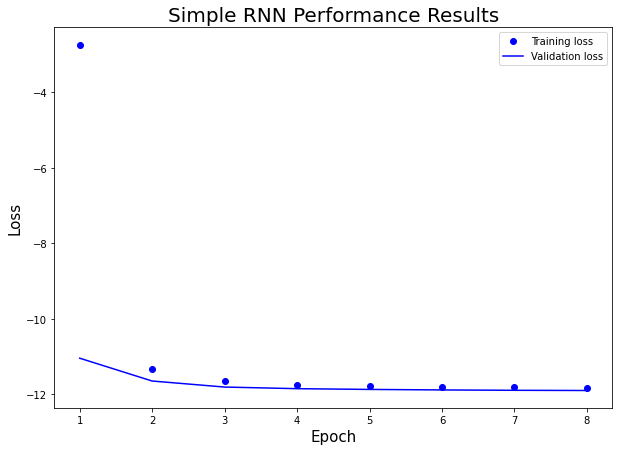

In [74]:
title = 'Simple RNN Performance Results'
plot_training_history(rnn_history, title, 'plots/RNNs/rnn_loss_mse.png')

In [76]:
# save model
model_name='model_RNN'
store_keras_model(rnn_model, model_name)
# rnn_model2 = load_keras_model(model_name)

# save history
save_model_history(rnn_history, "{}_history_dict".format(model_name))
rnn_history2 = load_model_history("{}_history_dict".format(model_name))

Saved model to disk


In [77]:
pred_cols = ['2012','2013','2014','2015','2016']

rnn_pred2 = rnn_model.predict(X_test_rnn_standardized4).reshape(y_test_rnn4.shape)
rnn_pred_df2 = compute_yr_preds(rnn_pred2, pred_cols)
rnn_true_df2 = compute_yr_preds(y_test_rnn4, pred_cols)

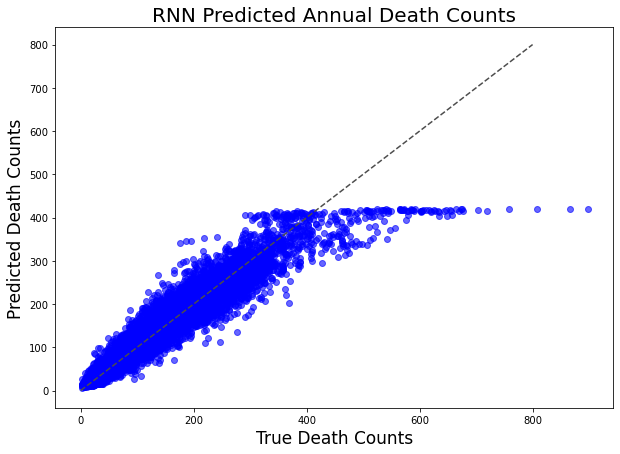

In [78]:
years = ['2012','2013','2014','2015','2016']

plt.figure(figsize=(10,7))
for y in years:
    plt.scatter(rnn_true_df2[y].values,rnn_pred_df2[y].values,c='blue',alpha=0.6)
plt.plot([0, 800], [0, 800], ls="--", c=".3")
plt.xlabel('True Death Counts',fontsize=17)
plt.ylabel('Predicted Death Counts', fontsize=17)
plt.title('RNN Predicted Annual Death Counts', fontsize=20)
# plt.legend()
plt.savefig('plots/RNNs/rnn_pred_v2.png')
plt.show()

In [79]:
rnn_r2s = []
rnn_mses = []
rnn_rmses = []
rnn_maes  = []
for y in years:
    rnn_r2s.append(r2_score(rnn_pred_df2[y].values, rnn_true_df2[y].values))
    rnn_mses.append(mean_squared_error(rnn_pred_df2[y].values, rnn_true_df2[y].values))
    rnn_rmses.append(mean_squared_error(rnn_pred_df2[y].values, rnn_true_df2[y].values, squared=False))
    rnn_maes.append(mean_absolute_error(rnn_pred_df2[y].values, rnn_true_df2[y].values))

print(np.mean(rnn_r2s))
print(np.mean(rnn_mses))
print(np.mean(rnn_rmses))
print(np.mean(rnn_maes))

0.9104864337022619
671.9521688489174
25.916593988956368
15.567051283875653


In [80]:
def build_rnn_model(n_units, xdim2, n_steps, batch_size, drop_rate, epochs, validation_split,
                    loss, metrics, optimizer, verbose):

    # define model
    rnn_model = tf.keras.Sequential()
    rnn_model.add(tf.keras.layers.Input(shape=(n_steps,xdim2)))
    rnn_model.add(tf.keras.layers.SimpleRNN(n_units,return_sequences=True)) 
    rnn_model.add(tf.keras.layers.BatchNormalization())           
    rnn_model.add(tf.keras.layers.Dropout(drop_rate))
    rnn_model.add(tf.keras.layers.SimpleRNN(n_units, return_sequences=True))
    rnn_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='relu')))
    
    # Compile model
    rnn_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return rnn_model

rnn_model

Simple LSTM

In [81]:
import tensorflow.keras.backend as kb

def custom_loss(y_actual,y_pred):
    
    cross_entropy = -tf.reduce_sum(tf.prod(y_actual, tf.math.log(tf.clip_by_value(y_pred,1e-10,1.0))))
    return cross_entropy

In [82]:
def get_lr_metric(optimizer): # to print out learning rate during model fitting
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def scheduler(epoch): # exponential decay of learning rate
    initial_lrate = 0.001
    if epoch < 3:
        lrate = initial_lrate
    else:
        lrate = initial_lrate*math.exp(0.1*(5-epoch))
    return lrate

In [83]:
# hyperparameters
n_units = 60
drop_rate = 0.1
# dim_embed = 50
lrate = LearningRateScheduler(scheduler)
callbacks_list = [lrate]

optimizer = tf.keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)
# loss = "mse"
loss=tf.keras.losses.Poisson()
metrics = [lr_metric, 'mse']

batch_size = 49
epochs = 10
validation_split = 0.1
verbose = 1

# try n_units = 50 (like paper)
# define model
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Input(shape=(n_steps,xdim2)))
lstm_model.add(tf.keras.layers.LSTM(n_units, return_sequences=True))
lstm_model.add(tf.keras.layers.BatchNormalization())
lstm_model.add(tf.keras.layers.LSTM(n_units, return_sequences=True))
lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='relu')))
# Compile model
lstm_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 60)            26880     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 60)            240       
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 60)            29040     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)             61        
Total params: 56,221
Trainable params: 56,101
Non-trainable params: 120
_________________________________________________________________


In [85]:
ind = list(range(len(X_train_rnn_standardized4)))
random.shuffle(ind)

lstm_history = lstm_model.fit(X_train_rnn_standardized4[[ind]], 
                              y_train_rnn4[[ind]], 
                              batch_size=batch_size, epochs=epochs, 
                              validation_split=validation_split, callbacks=callbacks_list,
                              verbose=verbose)

Epoch 1/10
11088/11088 [==============================] - 130s 12ms/step - loss: -11.4611 - lr: 0.0010 - mse: 18.5052 - val_loss: -11.8412 - val_lr: 0.0010 - val_mse: 11.5663
Epoch 2/10
11088/11088 [==============================] - 129s 12ms/step - loss: -11.8701 - lr: 0.0010 - mse: 11.1870 - val_loss: -11.8720 - val_lr: 0.0010 - val_mse: 10.5914
Epoch 3/10
11088/11088 [==============================] - 127s 11ms/step - loss: -11.8925 - lr: 0.0010 - mse: 10.4784 - val_loss: -11.8841 - val_lr: 0.0010 - val_mse: 10.2637
Epoch 4/10
11088/11088 [==============================] - 128s 12ms/step - loss: -11.9006 - lr: 0.0012 - mse: 10.2491 - val_loss: -11.8898 - val_lr: 0.0012 - val_mse: 10.0993
Epoch 5/10
11088/11088 [==============================] - 127s 11ms/step - loss: -11.9098 - lr: 0.0011 - mse: 10.0121 - val_loss: -11.8950 - val_lr: 0.0011 - val_mse: 9.9907
Epoch 6/10
11088/11088 [==============================] - 128s 12ms/step - loss: -11.9160 - lr: 0.0010 - mse: 9.8691 - val_los

In [79]:
ind = list(range(len(X_train_rnn_standardized4)))
random.shuffle(ind)

lstm_history = lstm_model.fit(X_train_rnn_standardized4[[ind]], 
                              y_train_rnn4_re[[ind]], 
                              batch_size=batch_size, epochs=epochs, 
                              validation_split=validation_split, callbacks=callbacks_list,
                              verbose=verbose)

Epoch 1/5
11043/11043 [==============================] - 170s 15ms/step - loss: -12.0843 - lr: 0.0010 - mse: 18.0555 - val_loss: -12.4264 - val_lr: 0.0010 - val_mse: 11.8283
Epoch 2/5
11043/11043 [==============================] - 173s 16ms/step - loss: -12.4565 - lr: 0.0010 - mse: 11.1636 - val_loss: -12.4602 - val_lr: 0.0010 - val_mse: 10.6604
Epoch 3/5
11043/11043 [==============================] - 168s 15ms/step - loss: -12.4788 - lr: 0.0010 - mse: 10.4413 - val_loss: -12.4775 - val_lr: 0.0010 - val_mse: 10.1498
Epoch 4/5
11043/11043 [==============================] - 163s 15ms/step - loss: -12.4877 - lr: 0.0012 - mse: 10.1765 - val_loss: -12.4835 - val_lr: 0.0012 - val_mse: 10.0370
Epoch 5/5
11043/11043 [==============================] - 171s 15ms/step - loss: -12.4983 - lr: 0.0011 - mse: 9.8824 - val_loss: -12.4897 - val_lr: 0.0011 - val_mse: 9.7714


In [32]:
# title = 'LSTM Performance Results'
# plot_training_history(lstm_history, title, 'lstm_loss.png')

In [86]:
# save model
model_name='model_LSTM'
store_keras_model(lstm_model, model_name)
# lstm_model2 = load_keras_model(model_name)

# save history
# x = tf.keras.optimizers.serialize(
#     lstm_model.optimizer)
# save_model_history(lstm_history, "{}_history_dict".format(model_name))
# write_config(lstm_model, "{}_config".format(model_name))
# lstm_config = read_config("{}_config".format(model_name))
# rnn_history2 = load_model_history("{}_history_dict".format(model_name))

Saved model to disk


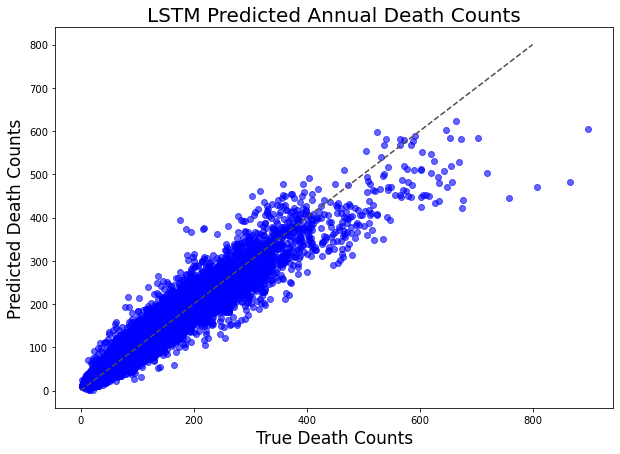

In [88]:
lstm_pred = lstm_model.predict(X_test_rnn_standardized4)
lstm_pred_df = compute_yr_preds(lstm_pred, pred_cols)
lstm_true_df = compute_yr_preds(y_test_rnn4, pred_cols)

years = ['2012','2013','2014','2015','2016']
# years=['2016']
plt.figure(figsize=(10,7))
for y in years:
    plt.scatter(lstm_true_df[y].values,lstm_pred_df[y].values,c='blue',alpha=0.6)
plt.plot([0, 800], [0, 800], ls="--", c=".3")
plt.xlabel('True Death Counts',fontsize=17)
plt.ylabel('Predicted Death Counts', fontsize=17)
plt.title('LSTM Predicted Annual Death Counts', fontsize=20)
plt.savefig('plots/RNNs/lstm_pred_v2.png')
plt.show()

In [89]:
lstm_r2s = []
lstm_mses = []
lstm_rmses = []
lstm_maes = []
for y in years:
    lstm_r2s.append(r2_score(lstm_pred_df[y].values, lstm_true_df[y].values))
    lstm_mses.append(mean_squared_error(lstm_pred_df[y].values, lstm_true_df[y].values))
    lstm_rmses.append(mean_squared_error(lstm_pred_df[y].values, lstm_true_df[y].values, squared=False))
    lstm_maes.append(mean_absolute_error(lstm_pred_df[y].values, lstm_true_df[y].values))

print(np.mean(lstm_r2s))
print(np.mean(lstm_mses))
print(np.mean(lstm_rmses))
print(np.mean(lstm_maes))

0.9233584034994997
602.7827998080699
24.54651206140991
15.420316926947384


LSTM 2

In [90]:
# input_layer = tf.keras.layers.Input(shape=(n_steps,xdim2))
# hidden1 = tf.keras.layers.LSTM(64, return_sequences=True)(input_layer)
# skip1 = tf.keras.layers.LSTM(64, return_sequences=True)(input_layer)

# hidden2 = tf.keras.layers.LSTM(64, return_sequences=True)(hidden1)
# hidden3 = tf.keras.layers.LSTM(64, return_sequences=True)(hidden2)

# skip_connect1 = tf.keras.layers.Add()([skip1,hidden3])
# hidden4 = tf.keras.layers.LSTM(128)(skip_connect1)
# x = tf.keras.layers.Dense(128,activation='relu')(hidden4)
# output_layer = tf.keras.layers.Dense(1,activation='relu')(x)

# lstm_model2 = tf.keras.Model(input_layer, output_layer)

# # Compile model
# lstm_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# lstm_model2.summary()

# https://stackoverflow.com/questions/60772323/how-to-implement-a-skip-connection-structure-between-lstm-layers

In [91]:
# lstm_history2 = lstm_model2.fit(X_train_rnn_normalized, 
#                               y_train_rnn, 
#                               batch_size=batch_size, epochs=epochs, 
#                               validation_split=validation_split, callbacks=callbacks_list,
#                               verbose=verbose)

GRU

In [92]:
# hyperparameters
n_units = 60
drop_rate = 0.1
# dim_embed = 50
# Define learning rate scheduler
lrate = LearningRateScheduler(scheduler)
callbacks_list = [lrate]


optimizer = tf.keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)
# loss = "mean_squared_error"
loss = tf.keras.losses.Poisson()
metrics = ['mse',lr_metric]

batch_size = 49
# batch_size = 256
# batch_size = 12
epochs = 8
validation_split = 0.1
verbose = 1
xdim2=len(x_col1)

# define model
gru_model = tf.keras.Sequential()
gru_model.add(tf.keras.layers.Input(shape=(12,xdim2)))
gru_model.add(tf.keras.layers.GRU(n_units, return_sequences=True,activation='relu')) 
# gru_model.add(tf.keras.layers.BatchNormalization())
gru_model.add(tf.keras.layers.Dropout(drop_rate))
gru_model.add(tf.keras.layers.GRU(n_units, return_sequences=True,activation='relu')) 
# gru_model.add(tf.keras.layers.Dropout(drop_rate))
# gru_model.add(tf.keras.layers.GRU(n_units, return_sequences=True)) 
gru_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='relu')))

# Compile model
gru_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# gru_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# gru_model2.summary()

In [93]:
ind = list(range(len(X_train_rnn_standardized4)))
random.shuffle(ind)

gru_history = gru_model.fit(X_train_rnn_standardized4[[ind]], y_train_rnn4[[ind]], 
                             batch_size = batch_size, epochs=epochs, 
                             validation_split=validation_split, 
                             callbacks=callbacks_list,
                             verbose=verbose)

Epoch 1/8
11088/11088 [==============================] - 108s 10ms/step - loss: -11.6601 - mse: 13.4767 - lr: 0.0010 - val_loss: -11.9096 - val_mse: 11.4548 - val_lr: 0.0010
Epoch 2/8
11088/11088 [==============================] - 105s 10ms/step - loss: -11.8623 - mse: 11.0020 - lr: 0.0010 - val_loss: -11.9351 - val_mse: 10.7546 - val_lr: 0.0010
Epoch 3/8
11088/11088 [==============================] - 106s 10ms/step - loss: -11.8795 - mse: 10.5801 - lr: 0.0010 - val_loss: -11.9404 - val_mse: 10.5999 - val_lr: 0.0010
Epoch 4/8
11088/11088 [==============================] - 106s 10ms/step - loss: -11.8863 - mse: 10.4224 - lr: 0.0012 - val_loss: -11.9516 - val_mse: 10.3716 - val_lr: 0.0012
Epoch 5/8
11088/11088 [==============================] - 106s 10ms/step - loss: -11.8932 - mse: 10.2549 - lr: 0.0011 - val_loss: -11.9538 - val_mse: 10.3277 - val_lr: 0.0011
Epoch 6/8
11088/11088 [==============================] - 106s 10ms/step - loss: -11.8982 - mse: 10.1411 - lr: 0.0010 - val_loss: -

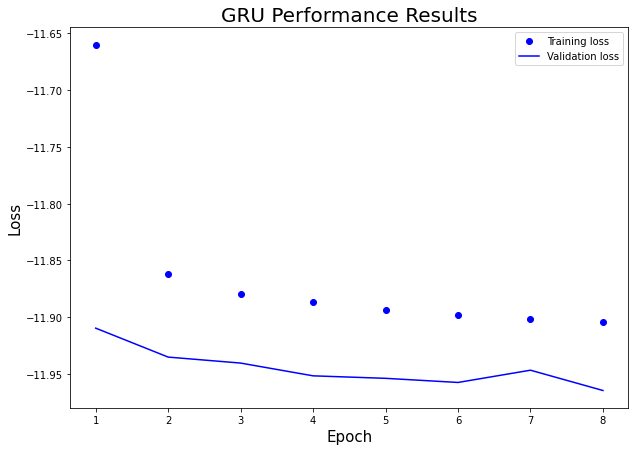

In [95]:
title = 'GRU Performance Results'
plot_training_history(gru_history, title, 'plots/RNNs/gru_loss_v2.png')

In [96]:
# save model
model_name='model_GRU'
store_keras_model(gru_model, model_name)
# rnn_model2 = load_keras_model(model_name)

# save history
# save_model_history(gru_history2, "{}_history_dict".format(model_name))
# rnn_history2 = load_model_history("{}_history_dict".format(model_name))

Saved model to disk


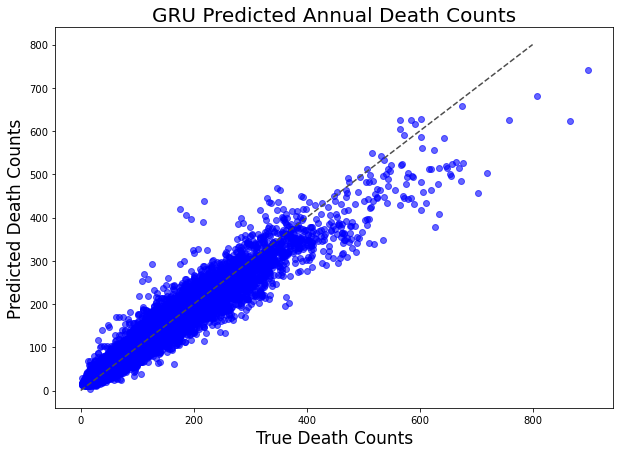

In [98]:
gru_pred = gru_model.predict(X_test_rnn_standardized4)
gru_pred_df = compute_yr_preds(gru_pred, pred_cols)
gru_true_df = compute_yr_preds(y_test_rnn4, pred_cols)

years = ['2012','2013','2014','2015','2016']
# years=['2016']
plt.figure(figsize=(10,7))
for y in years:
    plt.scatter(gru_true_df[y].values,gru_pred_df[y].values,color='blue',alpha=0.6)
plt.plot([0, 800], [0, 800], ls="--", c=".3")
plt.xlabel('True Death Counts',fontsize=17)
plt.ylabel('Predicted Death Counts', fontsize=17)
plt.title('GRU Predicted Annual Death Counts', fontsize=20)
plt.savefig('plots/RNNs/gru_pred_v2.png')
plt.show()

In [99]:
gru_r2s = []
gru_mses = []
gru_rmses = []
gru_maes = []
for y in years:
    gru_r2s.append(r2_score(gru_pred_df[y].values, gru_true_df[y].values))
    gru_mses.append(mean_squared_error(gru_pred_df[y].values, gru_true_df[y].values))
    gru_rmses.append(mean_squared_error(gru_pred_df[y].values, gru_true_df[y].values, squared=False))
    gru_maes.append(mean_absolute_error(gru_pred_df[y].values, gru_true_df[y].values))

print(np.mean(gru_r2s))
print(np.mean(gru_mses))
print(np.mean(gru_rmses))
print(np.mean(gru_maes))

0.9266853531686341
541.8840045011314
23.264054902995685
14.829285496602102


In [100]:
# gru_perm_effects = var_importance(gru_model2, X_train_rnn_standardized4, num_repeats=3)
# gru_perm_effects_repeat = pd.DataFrame(np.array(gru_perm_effects),columns=x_col1)
# gru_perm_effects_repeat.to_csv('gru_permutation_importance_3_repeats.csv')

In [101]:
# compares change in MSE - since MSE is our loss function
gru_perm_effects_test = var_importance(gru_model, X_test_rnn_standardized4, x_col1, num_repeats=10)

predicted original
repeat complete
repeat complete
repeat complete
repeat complete
repeat complete
repeat complete
repeat complete
repeat complete
repeat complete
repeat complete


In [102]:
gru_perm_effects_repeat_test = pd.DataFrame(np.array(gru_perm_effects_test),columns=x_col1)
gru_perm_effects_repeat_test.to_csv('gru_test_perm_importance_10_repeats.csv')

In [103]:
gru_perm_effects_repeat_test2 = gru_perm_effects_repeat_test.copy()

for i in range(5):
    gru_perm_effects_repeat_test2.loc[i] = gru_perm_effects_repeat_test.loc[i]/gru_perm_effects_repeat_test.loc[i].sum()
    
importances_mean_test = gru_perm_effects_repeat_test2.mean(axis=0).values
importances_test = gru_perm_effects_repeat_test2.values

In [1]:
# sorted_idx2 = importances_mean_test.argsort()

# f,ax = plt.subplots(1,figsize=(12,8))
# ax.boxplot(importances_test[:,sorted_idx2][:,-15:],
#             vert=False) # np.array(x_col1)[sorted_idx2][-15:] ,  labs[::-1]
# ax.set_yticklabels(labels=np.array(x_col1)[sorted_idx2][-15:],fontsize=12)
# plt.title("GRU Feature Importance (Test Set)",fontsize=20)
# plt.tight_layout()
# # plt.savefig('gru_perm_test_importance_10.png',dpi=300)
# plt.show()

In [2]:
# sorted_idx2 = importances_mean_test.argsort()
# labs = ['Population Size','CVD','Race: Hispanic',
#         'Med Household Income',
#         'Ave Age', 'OwnerOcc (%)',
#         'Summer Temp','Winter Temp','Race: Asian',
#         'year:2013','Med House Value',
#         'year:2011','year:2014','year:2012','year:2016']

# f,ax = plt.subplots(1,figsize=(12,8))
# ax.boxplot(importances_test[:,sorted_idx2][:,-15:],
#             vert=False) # np.array(x_col1)[sorted_idx2][-15:] ,  labs[::-1]
# ax.set_yticklabels(labels=labs[::-1],fontsize=12)
# plt.title("GRU Feature Importance (Test Set)",fontsize=25)
# plt.tight_layout()
# plt.savefig('gru_perm_test_importance_10.png',dpi=300)
# plt.show()

In [3]:
# sorted_idx = np.argsort(importances_mean_test)

# pos = np.arange(sorted_idx.shape[0]) + .5
# fig = plt.figure(figsize=(30, 10))
# plt.subplot(1, 2, 1)
# plt.barh(pos[-15:], importances_mean_test[sorted_idx][-15:], align='center')
# plt.yticks(pos[-15:], labs[::-1],fontsize=12)
# plt.title('GRU Feature Importance (Test Set)',fontsize=20)
# plt.tight_layout()
# plt.savefig('gru_feature_test_importance_10.png',dpi=300)
# plt.show()

GRU Robustness

In [ ]:
def build_gru_model(params):
    lr = params['lr']
    n_trees = params['n_trees']
    max_depth = params['max_depth']
    sprop = params['sprop']
    max_feats='sqrt'
    
    gbr_model = GradientBoostingRegressor(learning_rate=lr,
                                      n_estimators=n_trees,
                                      max_depth=max_depth,
                                      subsample=sprop,
                                      max_features=max_feats,
                                     loss='ls')
    return gbr_model

def check_robustness(df_train, x_col, y_col, params, build_gbr_model):

    train_scores = []
    test_scores = []
    train_mse = []
    test_mse = [] 
    non_binary_preds = x_col
    train_preds = []
    test_preds = []
              
    for i in range(10):
        # resample and shuffle
        X_train_standardized, y_train, X_test_standardized, y_test, s = split_and_standardize2(df_train, x_col, y_col, non_binary_preds, shuffle=True)
        
        # build gbr
        model = build_gbr_model(params)
        
        # fit and predict
        model.fit(X_train_standardized, y_train)
        gbr_test_pred = model.predict(X_test_standardized)  
        gbr_train_pred = model.predict(X_train_standardized)  
        
        train_scores.append(model.score(X_train_standardized, y_train))
        test_scores.append(model.score(X_test_standardized, y_test))
        print(train_scores[-1],test_scores[-1])
        
        train_mse.append(mean_squared_error(y_train, gbr_train_pred))
        test_mse.append(mean_squared_error(y_test, gbr_test_pred))
        train_preds.append(gbr_train_pred)
        test_preds.append(gbr_test_pred)
        print('completed round')
                    
    return train_scores, test_scores, train_mse, test_mse, train_preds, test_preds

Bidirectional GRU

In [110]:
# hyperparameters
n_units1 = 60
n_units2 = 60
drop_rate = 0.1
# dim_embed = 50
# Define learning rate scheduler
lrate = LearningRateScheduler(scheduler)
callbacks_list = [lrate]

optimizer = tf.keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)
# loss = "mean_squared_error"
loss = tf.keras.losses.Poisson()
metrics = ['mse', lr_metric]

batch_size = 49
epochs = 8
validation_split = 0.15
verbose = 1

# define model
bigru_model = tf.keras.Sequential()
bigru_model.add(tf.keras.layers.Input(shape=(12,xdim2)))
bigru_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units1, return_sequences=True)))
bigru_model.add(tf.keras.layers.BatchNormalization())
bigru_model.add(tf.keras.layers.Dropout(drop_rate))
bigru_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units2, return_sequences=True)))
bigru_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='relu')))
# Compile model

# Fit
bigru_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
bigru_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 12, 120)           40680     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 120)           480       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 120)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 12, 120)           65520     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 1)             121       
Total params: 106,801
Trainable params: 106,561
Non-trainable params: 240
_________________________________________________________________


In [111]:
ind = list(range(len(X_train_rnn_standardized4)))
random.shuffle(ind)

bigru_history = bigru_model.fit(X_train_rnn_standardized4[[ind]], 
                                y_train_rnn4[[ind]], batch_size=batch_size, epochs=epochs, 
                                validation_split=validation_split, 
                                callbacks=callbacks_list,verbose=verbose)

Epoch 1/8
10472/10472 [==============================] - 157s 15ms/step - loss: -11.5188 - mse: 15.5073 - lr: 0.0010 - val_loss: -11.9208 - val_mse: 11.2421 - val_lr: 0.0010
Epoch 2/8
10472/10472 [==============================] - 153s 15ms/step - loss: -11.8756 - mse: 10.8826 - lr: 0.0010 - val_loss: -11.9504 - val_mse: 10.3852 - val_lr: 0.0010
Epoch 3/8
10472/10472 [==============================] - 153s 15ms/step - loss: -11.8985 - mse: 10.2112 - lr: 0.0010 - val_loss: -11.9635 - val_mse: 9.9019 - val_lr: 0.0010
Epoch 4/8
10472/10472 [==============================] - 152s 15ms/step - loss: -11.9064 - mse: 9.9834 - lr: 0.0012 - val_loss: -11.9651 - val_mse: 9.8587 - val_lr: 0.0012
Epoch 5/8
10472/10472 [==============================] - 152s 15ms/step - loss: -11.9150 - mse: 9.7604 - lr: 0.0011 - val_loss: -11.9738 - val_mse: 9.6463 - val_lr: 0.0011
Epoch 6/8
10472/10472 [==============================] - 152s 15ms/step - loss: -11.9208 - mse: 9.6171 - lr: 0.0010 - val_loss: -11.978

In [45]:
ind = list(range(len(X_train_rnn_standardized4)))
random.shuffle(ind)

bigru_history = bigru_model.fit(X_train_rnn_standardized4[[ind]], 
                                y_train_rnn4_re[[ind]], batch_size=batch_size, epochs=epochs, 
                                validation_split=validation_split, 
                                callbacks=callbacks_list,verbose=verbose)

Epoch 1/5
8004/8004 [==============================] - 200s 25ms/step - loss: -11.0514 - mse: 19.7704 - lr: 9.9995e-04 - val_loss: -15.9020 - val_mse: 21.3316 - val_lr: 0.0010
Epoch 2/5
8004/8004 [==============================] - 196s 25ms/step - loss: -11.7307 - mse: 11.1712 - lr: 9.9995e-04 - val_loss: -15.8533 - val_mse: 22.7365 - val_lr: 0.0010
Epoch 3/5
8004/8004 [==============================] - 195s 24ms/step - loss: -11.7667 - mse: 10.0560 - lr: 9.9995e-04 - val_loss: -15.8566 - val_mse: 22.8471 - val_lr: 0.0010
Epoch 4/5
8004/8004 [==============================] - 190s 24ms/step - loss: -11.7812 - mse: 9.6199 - lr: 0.0012 - val_loss: -15.8934 - val_mse: 21.9921 - val_lr: 0.0012
Epoch 5/5
8004/8004 [==============================] - 195s 24ms/step - loss: -11.7950 - mse: 9.2338 - lr: 0.0011 - val_loss: -15.8240 - val_mse: 23.9841 - val_lr: 0.0011


In [171]:
# title = 'BIGRU Performance Results'
# plot_training_history(bigru_history, title, 'bigru_loss.png')

In [112]:
# save model
model_name='model_BIGRU'
store_keras_model(bigru_model, model_name)
# rnn_model2 = load_keras_model(model_name)

# save history
# save_model_history(bigru_history, "{}_history_dict".format(model_name))
# rnn_history2 = load_model_history("{}_history_dict".format(model_name))

Saved model to disk


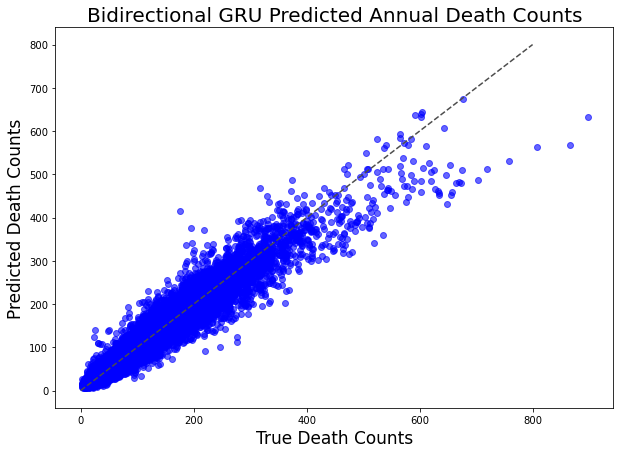

In [114]:
bigru_pred =bigru_model.predict(X_test_rnn_standardized4)
bigru_pred_df = compute_yr_preds(bigru_pred, pred_cols)
bigru_true_df = compute_yr_preds(y_test_rnn4, pred_cols)

years = ['2012','2013','2014','2015','2016']
# years=['2016']
plt.figure(figsize=(10,7))
for y in years:
    plt.scatter(bigru_true_df[y].values,bigru_pred_df[y].values,color='blue',alpha=0.6)
plt.plot([0, 800], [0, 800], ls="--", c=".3")
plt.xlabel('True Death Counts',fontsize=17)
plt.ylabel('Predicted Death Counts', fontsize=17)
plt.title('Bidirectional GRU Predicted Annual Death Counts', fontsize=20)
# plt.savefig('bigru_pred_v2.png')
plt.show()

In [115]:
bigru_r2s = []
bigru_mses = []
bigru_rmses = []
bigru_maes = []
for y in years:
    bigru_r2s.append(r2_score(bigru_pred_df[y].values, bigru_true_df[y].values))
    bigru_mses.append(mean_squared_error(bigru_pred_df[y].values,bigru_true_df[y].values))
    bigru_rmses.append(mean_squared_error(bigru_pred_df[y].values, bigru_true_df[y].values, squared=False))
    bigru_maes.append(mean_absolute_error(bigru_pred_df[y].values, bigru_true_df[y].values))

print(np.mean(bigru_r2s))
print(np.mean(bigru_mses))
print(np.mean(bigru_rmses))
print(np.mean(bigru_maes))

0.9258816029974677
584.9320541198131
24.173851920638196
15.401841516448041


In [74]:
bigru_pred_df.to_csv('bigru_test_pred_results.csv')

In [136]:
len(x_col1),X_train_rnn_standardized4.shape

(55, (601181, 12, 54))

In [131]:
def build_bigru(nsteps, xdim2, n_units1,n_units2,drop_rate,scheduler,optimizer,lr_metric,loss,metric,
               batch_size,epochs,validation_split,verbose):
    
    lrate = LearningRateScheduler(scheduler)
    callbacks_list = [lrate]
    lr_metric = get_lr_metric(optimizer)
    metrics = [metric, lr_metric]

    # define model
    bigru_model = tf.keras.Sequential()
    bigru_model.add(tf.keras.layers.Input(shape=(nsteps,xdim2)))
    bigru_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units1, return_sequences=True)))
    bigru_model.add(tf.keras.layers.BatchNormalization())
    bigru_model.add(tf.keras.layers.Dropout(drop_rate))
    bigru_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units2, return_sequences=True)))
    bigru_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='relu')))
    # Compile model
    bigru_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return bigru_model

def check_robustness()
 
    n_units1 = 60
    n_units2 = 60
    drop_rate = 0.1
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.Poisson()
    metric='mse'
    batch_size = 49
    epochs = 8
    validation_split = 0.15
    verbose = 1
    
    # randomly split into train and test, shuffle
    ## for i in range(10);
    # build model
    # predict
    # score
    # save results

773759

In [ ]:
# concat everything
x=np.concat((X_train_rnn_standardized4, X_test_rnn_standardized4,axis=0))
y=np.concat((y_train_rnn4, y_train_rnn4,axis=0))
x2 = np.concat((x,y,axis=1))



Bidirectional  gru 2
-skip connnection
- y is next month after 11 month window passed in

In [22]:
input_layer = tf.keras.layers.Input(shape=(n_steps,xdim2))

hidden1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, return_sequences=True))(input_layer)
hidden2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, return_sequences=True))(hidden1)
skip1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100))(hidden1)
skip_connect1 = tf.keras.layers.Add()([skip1,hidden2])
x = tf.keras.layers.Dense(128,activation='relu')(skip_connect1)
output_layer = tf.keras.layers.Dense(1,activation='relu')(x)

bigru_model2 = tf.keras.Model(input_layer, output_layer)

# Compile model
bigru_model2.compile(optimizer=optimizer, loss=loss, metrics=metrics)
bigru_model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 12, 58)]     0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 12, 200)      96000       input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 200)          181200      bidirectional_10[0][0]           
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional (None, 12, 200)      181200      bidirectional_10[0][0]           
_______________________________________________________________________________________

### Plot all predictions in subplot

In [74]:
# Plot history
def plot_all_training_history(models_history, titles, save_label):
    f, axes = plt.subplots(2,2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(4):
        loss = models_history[i].history['loss']
        val_loss = models_history[i].history['val_loss']
        epochs = range(1,len(loss)+1)

        axes[i].plot(epochs, loss, 'bo', label='Training loss')
        axes[i].plot(epochs, val_loss, 'b', label='Validation loss')
        axes[i].set_title(titles[i],fontsize=20)
        axes[i].set_xticks(epochs)
        axes[i].set_xlabel('Epoch', fontsize=15)
        axes[i].set_ylabel("Loss",fontsize=15)
        axes[i].legend()
    plt.suptitle("Sequential Models Training Performance", fontsize=25)
    plt.tight_layout()
    plt.savefig(save_label)
    plt.show()

In [120]:
models_history = [rnn_history, lstm_history, gru_history, bigru_history]
titles = ['RNN', 'LSTM', 'GRU', 'Bidirectional GRU']

# plot_all_training_history(models_history, titles, 'plots/RNNs/all_rnn_histories_v2.png')

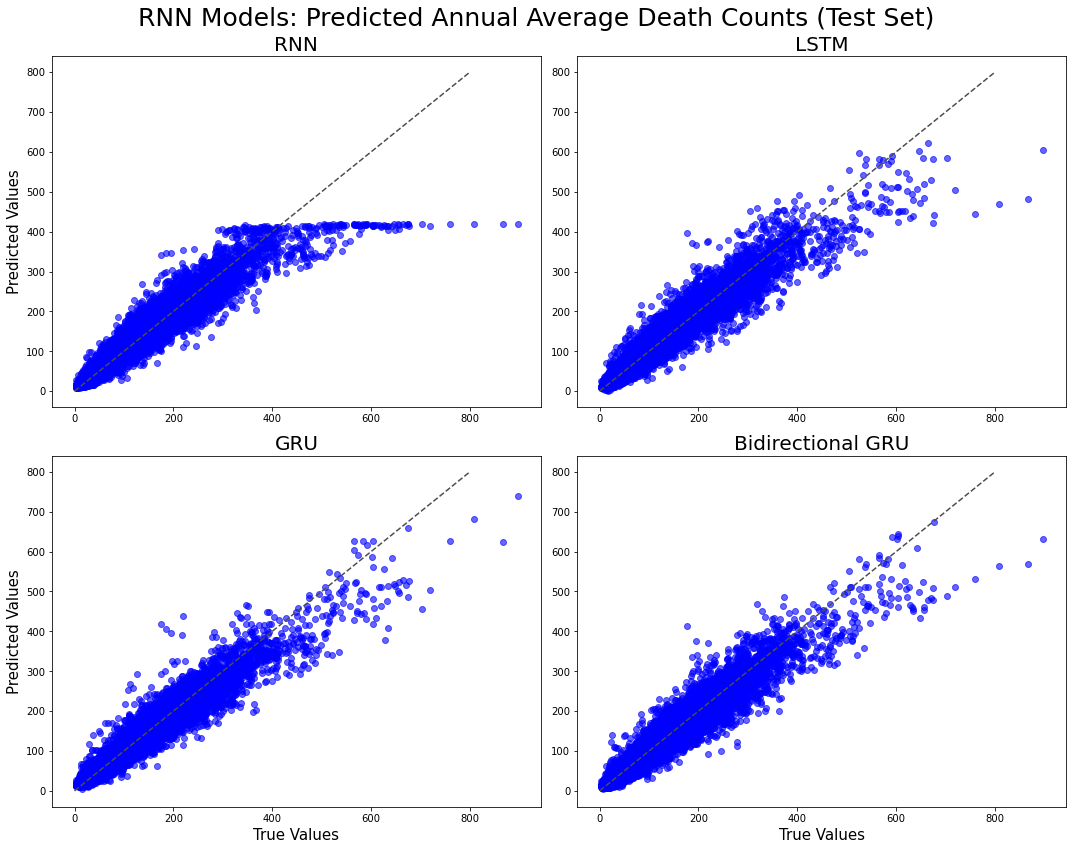

In [117]:
years = ['2012','2013','2014','2015','2016']
titles = ['RNN', 'LSTM', 'GRU', 'Bidirectional GRU']
true_dfs = [rnn_true_df2,lstm_true_df,gru_true_df,bigru_true_df]
pred_dfs = [rnn_pred_df2,lstm_pred_df,gru_pred_df,bigru_pred_df]

fig, axes = plt.subplots(2,2,figsize=(15,12))
axes = axes.ravel()

for i in range(4):
    for y in years:
        axes[i].scatter(true_dfs[i][y].values, pred_dfs[i][y].values,color='blue',alpha=0.6)
    axes[i].plot([0, 800], [0, 800], ls="--", c=".3")
    axes[i].set_title(titles[i],fontsize=20)
    if i == 2 or i ==3:
        axes[i].set_xlabel('True Values',fontsize=15)
    if i == 0 or i ==2:
        axes[i].set_ylabel('Predicted Values',fontsize=15)
#     axes[i].legend()
    
plt.suptitle('RNN Models: Predicted Annual Average Death Counts (Test Set)', fontsize=25)
plt.tight_layout()
plt.savefig('plots/RNNs/all_rnns_performance.png')
plt.show()

In [78]:
rnn_names = ['rnn_pred_test_vals.csv','lstm_pred_test_vals.csv','gru_pred_test_vals.csv','lstm_pred_test_vals.csv']
true_dfs[0].to_csv('rnn_true_test_vals.csv')
for i in range(4):
    pred_dfs[i].to_csv(rnn_names[i])

K Fold cross validation for deep learning

https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
https://machinelearningmastery.com/keras-functional-api-deep-learning/

RNN time series

https://www.guru99.com/rnn-tutorial.html

In [82]:
from sklearn.model_selection import KFold, StratifiedKFold

def create_new_model():
    # hyperparameters
    n_units1 = 60
    n_units2 = 60
    drop_rate = 0.15

    # define model
    bigru_model = tf.keras.Sequential()
    bigru_model.add(tf.keras.layers.Input(shape=(12,xdim2)))
    bigru_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units1, return_sequences=True)))
    bigru_model.add(tf.keras.layers.BatchNormalization())
    bigru_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units2, return_sequences=True)))
    bigru_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='linear')))
    
    return bigru_model

bm = create_new_model()

In [ ]:
val_acc = []
val_loss = []

save_dir = '/saved_models/'
fold_var = 1

optimizer = tf.keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)
loss = "mean_squared_error"
metrics = ['accuracy', lr_metric]

batch_size = 64
epochs = 5
validation_split = 0.15
verbose = 1

for train_index, val_index in kf.split(np.zeros(n),Y):
    trai_data = train_data.iloc[train_index]
    val_data = train_data.iloc[val_index]

    # CREATE NEW MODEL
    model = create_new_model()
    # COMPILE NEW MODEL
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                monitor='val_accuracy', verbose=1, 
                                save_best_only=True, mode='max')
    
    lrate = LearningRateScheduler(scheduler)
    callbacks_list = [checkpoint, lrate]
        # There can be other callbacks, but just showing one because it involves the model name
        # This saves the best model
        # FIT THE MODEL
    history = model.fit(train_data,
                epochs=epochs,
                callbacks=callbacks_list,
                validation_data=val_data)

    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(val_data)
    results = dict(zip(model.metrics_names,results))

    val_acc.append(results['accuracy'])
    val_loss.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1

# Appendix Code

In [ ]:
#  difference variations of x and y
x_col1 = ['ICU_DAY', 'CCI_DAY', 'LOS', 'Stroke_pdx2dx_25',
             'CVD_pdx2dx_25']

# including deaths from current year as a predictor for deaths next year
x_col2 = ['sex','age','poverty', 'popdensity', 'medianhousevalue',
       'medhouseholdincome', 'pct_owner_occ', 'education',
       'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'ICU_DAY',
       'CCI_DAY', 'LOS', 'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25',
       'Dementia_pdx2dx_25', 'CHF_pdx2dx_25', 'AMI_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25', 'CVD_pdx2dx_25',
       'CSD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25', 'Hemo_Stroke_pdx2dx_25',
       'neo_140_149', 'neo_150_159', 'neo_160_165', 'neo_170_176',
       'neo_179_189', 'neo_190_199', 'neo_200_209', 'neo_210_229',
       'neo_230_234', 'neo_235_238', 'neo_239', 'pm25_summer_4y_avg',
       'pm25_winter_4y_avg', 'pm25_fall_4y_avg', 'pm25_spring_4y_avg',
       'ozone_summer_4y_avg', 'ozone_winter_4y_avg', 'ozone_fall_4y_avg',
       'ozone_spring_4y_avg', 'no2_summer_4y_avg', 'no2_winter_4y_avg',
       'no2_fall_4y_avg', 'no2_spring_4y_avg', 'summer_tmmx_4y_avg',
       'summer_rmax_4y_avg', 'winter_tmmx_4y_avg', 'winter_rmax_4y_avg',
       'm_count', 'f_count', 'mean_age', 'white_count', 'black_count',
       'hispanic_count', 'asian_count', 'native_count', 'monthly_pop', 'deaths']

y_col1 = ['deaths_next_year']
n_steps = 11

X_train_rnn1, y_train_rnn1 = split_sequence(df_train_agg1, x_col2, y_col1, n_steps)
X_test_rnn1, y_test_rnn1 = split_sequence(df_test_agg1, x_col2, y_col1, n_steps)

X_train_rnn2, y_train_rnn2 = split_sequence2(df_train_agg1, x_col2, y_col1, n_steps)
X_test_rnn2, y_test_rnn2 = split_sequence2(df_test_agg1, x_col2, y_col1, n_steps)

#

In [ ]:
# deaths shifted one time step ahead, y: next month, or shifted next 11 months by 1 month
x_col1 = ['ICU_DAY', 'CCI_DAY', 'LOS', 'Stroke_pdx2dx_25',
             'CVD_pdx2dx_25']

# including deaths from current year as a predictor for deaths next year
x_col2 = ['sex','age','poverty', 'popdensity', 'medianhousevalue',
       'medhouseholdincome', 'pct_owner_occ', 'education',
       'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'ICU_DAY',
       'CCI_DAY', 'LOS', 'Parkinson_pdx2dx_25', 'Alzheimer_pdx2dx_25',
       'Dementia_pdx2dx_25', 'CHF_pdx2dx_25', 'AMI_pdx2dx_25',
       'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25', 'CVD_pdx2dx_25',
       'CSD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25', 'Hemo_Stroke_pdx2dx_25',
       'neo_140_149', 'neo_150_159', 'neo_160_165', 'neo_170_176',
       'neo_179_189', 'neo_190_199', 'neo_200_209', 'neo_210_229',
       'neo_230_234', 'neo_235_238', 'neo_239', 'pm25_summer_4y_avg',
       'pm25_winter_4y_avg', 'pm25_fall_4y_avg', 'pm25_spring_4y_avg',
       'ozone_summer_4y_avg', 'ozone_winter_4y_avg', 'ozone_fall_4y_avg',
       'ozone_spring_4y_avg', 'no2_summer_4y_avg', 'no2_winter_4y_avg',
       'no2_fall_4y_avg', 'no2_spring_4y_avg', 'summer_tmmx_4y_avg',
       'summer_rmax_4y_avg', 'winter_tmmx_4y_avg', 'winter_rmax_4y_avg',
       'm_count', 'f_count', 'mean_age', 'white_count', 'black_count',
       'hispanic_count', 'asian_count', 'native_count', 'monthly_pop', 'deaths']

y_col1 = ['deaths_next_year']
n_steps = 11

X_train_rnn1, y_train_rnn1 = split_sequence(df_train_agg1, x_col2, y_col1, n_steps)
X_test_rnn1, y_test_rnn1 = split_sequence(df_test_agg1, x_col2, y_col1, n_steps)
# reshape to 2D for normalizing
xdim2 = len(x_col2)

X_train_rnn1_re = X_train_rnn1.reshape((X_train_rnn1.shape[0]*X_train_rnn1.shape[1]*n_steps,xdim2))
X_test_rnn1_re = X_test_rnn1.reshape((X_test_rnn1.shape[0]*X_test_rnn1.shape[1]*n_steps,xdim2))
y_train_rnn1_re = y_train_rnn1.reshape((y_train_rnn1.shape[0]*y_train_rnn1.shape[1],n_steps))
y_test_rnn1_re = y_test_rnn1.reshape((y_test_rnn1.shape[0]*y_test_rnn1.shape[1],n_steps))

# normalize
X_train_rnn_normalized1, X_test_rnn_normalized1 =normalize_data(X_train_rnn1_re, X_test_rnn1_re)

# reshape to 3D for RNN input
X_train_rnn_normalized1 = X_train_rnn_normalized1.reshape((X_train_rnn1.shape[0]*X_train_rnn1.shape[1],n_steps,xdim2))
X_test_rnn_normalized1 = X_test_rnn_normalized1.reshape((X_test_rnn1.shape[0]*X_test_rnn1.shape[1],n_steps,xdim2))


X_train_rnn2, y_train_rnn2 = split_sequence2(df_train_agg1, x_col2, y_col1, n_steps)
X_test_rnn2, y_test_rnn2 = split_sequence2(df_test_agg1, x_col2, y_col1, n_steps)

X_train_rnn2_re = X_train_rnn2.reshape((X_train_rnn2.shape[0]*X_train_rnn2.shape[1]*n_steps,xdim2))
X_test_rnn2_re = X_test_rnn2.reshape((X_test_rnn2.shape[0]*X_test_rnn2.shape[1]*n_steps,xdim2))

# normalize
X_train_rnn_normalized2, X_test_rnn_normalized2 =normalize_data(X_train_rnn2_re, X_test_rnn2_re)

# reshape to 3D for RNN input
X_train_rnn_normalized2 = X_train_rnn_normalized2.reshape((X_train_rnn2.shape[0]*X_train_rnn2.shape[1],n_steps,xdim2))
X_test_rnn_normalized2 = X_test_rnn_normalized2.reshape((X_test_rnn2.shape[0]*X_test_rnn2.shape[1],n_steps,xdim2))

In [ ]:
def split_sequence(df, x_cols, y_col, n_steps):
    X,y = [],[] 
    zips = np.unique(df.zip)
    
    # loop through all zips
    for i in range(zips.shape[0]): 
        
        X_sub, y_sub = [],[]
        
        # subset to this zipcode
        df_zip = df[df.zip == zips[i]]
        full_dim = df_zip.shape[0]
        
        for j in range(full_dim):
            # find the end of this pattern
            end_jx = j + n_steps
    #         out_end_ix = end_ix + n_steps

            # check if we are beyond the sequence
            if end_jx > full_dim:
                break

            # else, gather input and output parts of the pattern
            x_sub_seq = df_zip[x_cols].iloc[j:end_jx]
            y_sub_seq = df_zip[y_col].iloc[j:end_jx]

            X_sub.append(x_sub_seq.values)
            y_sub.append(y_sub_seq.values)

        X.append(X_sub)
        y.append(y_sub)
    
    #  return nex index
    return np.array(X), np.array(y)

def split_sequence2(df, x_cols, y_col, n_steps):
    X,y = [],[] 
    zips = np.unique(df.zip)
    
    # loop through all zips
    for i in range(zips.shape[0]): 
        
        X_sub, y_sub = [],[]
        
        # subset to this zipcode
        df_zip = df[df.zip == zips[i]]
        full_dim = df_zip.shape[0]
        
        for j in range(full_dim):
            # find the end of this pattern
            end_jx = j + n_steps
    #         out_end_ix = end_ix + n_steps

            # check if we are beyond the sequence
            if end_jx > full_dim:
                break

            # else, gather input and output parts of the pattern
            x_sub_seq = df_zip[x_cols].iloc[j:end_jx]
#             print(j,end_jx)
            y_sub_seq = df_zip[y_col].iloc[end_jx-1]

            X_sub.append(x_sub_seq.values)
            y.append(y_sub_seq.values)

        X.append(X_sub)
#         y.append(y_sub)
#         break
    
    #  return nex index
    return np.array(X), np.array(y) 

Basic FFNN

In [ ]:
groupby_cols2 = ['zip','AYEAR','month_continuous']
df_train_agg2,df_test_agg2 = agg_monthly(col_to_agg, df_train, df_test, groupby_cols2)

x_col2 = ['sex', 'age','poverty', 'popdensity', 'medianhousevalue', 
        'medhouseholdincome', 'pct_owner_occ','education',
        'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'race_0', 'race_1', 'race_2',
        'race_3', 'race_4', 'race_5', 'race_6','ICU_DAY', 'CCI_DAY', 'LOS', 
        'Parkinson_pdx2dx_25','Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25', 'CHF_pdx2dx_25',
       'AMI_pdx2dx_25', 'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25',
       'CVD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25','Hemo_Stroke_pdx2dx_25',
        'neo_140_149', 'neo_150_159', 'neo_160_165',
       'neo_170_176', 'neo_179_189', 'neo_190_199', 'neo_200_209',
       'neo_210_229', 'neo_230_234', 'neo_235_238', 'neo_239','pm25_summer_4y_avg', 
       'pm25_winter_4y_avg', 'pm25_fall_4y_avg', 'pm25_spring_4y_avg','ozone_summer_4y_avg', 'ozone_winter_4y_avg', 
       'ozone_fall_4y_avg', 'ozone_spring_4y_avg','no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg', 
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg','summer_rmax_4y_avg', 'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

x_col_pre = ['month_continuous','ICU_DAY', 'CCI_DAY', 'LOS', 'Stroke_pdx2dx_25',
             'CVD_pdx2dx_25']
        #'Parkinson_pdx2dx_25','Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25', 'CHF_pdx2dx_25',
       #'AMI_pdx2dx_25', 'COPD_pdx2dx_25', 'DM_pdx2dx_25', 
#        'Ischemic_stroke_pdx2dx_25','Hemo_Stroke_pdx2dx_25']

y_col = 'deaths'
non_binary_preds = x_col_pre

# split into train and test and standardize for FFNN
X_train_standardized, y_train, X_test_standardized, y_test = split_and_standardize(df_train_agg2, x_col_pre, y_col, non_binary_preds
                                                                                   
                                                                                   model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=(6,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss='mean_squared_error',
             metrics=['mse'])

ffnn_history = model.fit(X_train_standardized, y_train, epochs=10, validation_split=0.1,
                    batch_size=32, verbose=1)

ffnn_test_pred = model.predict(X_test_standardized)

In [ ]:
# explainer = lime.lime_tabular.LimeTabularExplainer(X_train_normalized3,
#                                                    mode='regression',
#                                                    feature_names=x_col1)